In [9]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:

# ------------------------------
# Hierarchical VAE Model (two-level) definition
# ------------------------------
class HierarchicalVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, z1_dim=20, z2_dim=10):
        super(HierarchicalVAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.z1_dim = z1_dim
        self.z2_dim = z2_dim

        # Encoder: from x to shared hidden representation
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # For top-level latent z2
        self.fc_z2_mu = nn.Linear(hidden_dim, z2_dim)
        self.fc_z2_logvar = nn.Linear(hidden_dim, z2_dim)
        
        # For lower-level latent z1; we condition on the hidden rep and z2
        self.fc_z1 = nn.Linear(hidden_dim + z2_dim, hidden_dim)
        self.fc_z1_mu = nn.Linear(hidden_dim, z1_dim)
        self.fc_z1_logvar = nn.Linear(hidden_dim, z1_dim)
        
        # Prior network: p(z1|z2) parameters, computed from z2
        self.fc_prior = nn.Linear(z2_dim, hidden_dim)
        self.fc_prior_mu = nn.Linear(hidden_dim, z1_dim)
        self.fc_prior_logvar = nn.Linear(hidden_dim, z1_dim)

        # Decoder: generate x from z1 and z2
        self.fc_dec = nn.Linear(z1_dim + z2_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        # Top-level latent q(z2|x)
        z2_mu = self.fc_z2_mu(h)
        z2_logvar = self.fc_z2_logvar(h)
        z2_std = torch.exp(0.5 * z2_logvar)
        eps = torch.randn_like(z2_std)
        z2 = z2_mu + eps * z2_std

        # For z1, condition on h and z2
        h_cat = torch.cat([h, z2], dim=1)
        h_z1 = F.relu(self.fc_z1(h_cat))
        z1_mu = self.fc_z1_mu(h_z1)
        z1_logvar = self.fc_z1_logvar(h_z1)
        z1_std = torch.exp(0.5 * z1_logvar)
        eps = torch.randn_like(z1_std)
        z1 = z1_mu + eps * z1_std

        return z1, z2, z1_mu, z1_logvar, z2_mu, z2_logvar

    def prior_z1(self, z2):
        h_prior = F.relu(self.fc_prior(z2))
        prior_mu = self.fc_prior_mu(h_prior)
        prior_logvar = self.fc_prior_logvar(h_prior)
        return prior_mu, prior_logvar

    def decode(self, z1, z2):
        z = torch.cat([z1, z2], dim=1)
        h = F.relu(self.fc_dec(z))
        x_logits = self.fc_out(h)
        return x_logits

    def forward(self, x):
        # x shape: (batch, 784)
        x = x.view(x.size(0), -1)
        z1, z2, z1_mu, z1_logvar, z2_mu, z2_logvar = self.encode(x)
        x_logits = self.decode(z1, z2)
        prior_mu, prior_logvar = self.prior_z1(z2)
        return x_logits, z1_mu, z1_logvar, z2_mu, z2_logvar, prior_mu, prior_logvar

# ------------------------------
# Helper functions for KL divergence
# ------------------------------
def kl_divergence(mu, logvar):
    # KL divergence for a diagonal Gaussian N(mu, var) from N(0,I)
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

def kl_divergence_gaussians(mu_q, logvar_q, mu_p, logvar_p):
    # KL divergence between two diagonal Gaussians
    var_q = logvar_q.exp()
    var_p = logvar_p.exp()
    kld = 0.5 * torch.sum(logvar_p - logvar_q + (var_q + (mu_q - mu_p).pow(2)) / var_p - 1, dim=1)
    return kld

# ------------------------------
# Loss Function (ELBO)
# ------------------------------
def loss_function(x_logits, x, z1_mu, z1_logvar, z2_mu, z2_logvar, prior_mu, prior_logvar):
    # Reconstruction loss: binary cross entropy
    BCE = F.binary_cross_entropy_with_logits(x_logits, x.view(-1, 784), reduction='sum')
    # KL divergence for z2 vs standard normal
    KL_z2 = kl_divergence(z2_mu, z2_logvar).sum()
    # KL divergence for z1 vs conditional prior p(z1|z2)
    KL_z1 = kl_divergence_gaussians(z1_mu, z1_logvar, prior_mu, prior_logvar).sum()
    return BCE + KL_z2 + KL_z1

# ------------------------------
# Load UC Merged Dataset and Split into Train/Test
# ------------------------------

# Define transforms (resize to 28x28 and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),  # if images are color, convert to grayscale
    transforms.ToTensor()
])

In [12]:
import zipfile
import os

# Specify the path to your ZIP file and the directory where you want to extract it
zip_file_path = 'UCMerced_LandUse.zip'
extract_dir = 'path/to/extracted_directory'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Open and extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to {extract_dir}")


Files extracted to path/to/extracted_directory


In [24]:
def kl_divergence(mu, logvar):
    # KL divergence for a diagonal Gaussian N(mu, var) from N(0,I)
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

def kl_divergence_gaussians(mu_q, logvar_q, mu_p, logvar_p):
    # KL divergence between two diagonal Gaussians
    var_q = logvar_q.exp()
    var_p = logvar_p.exp()
    kld = 0.5 * torch.sum(
        logvar_p - logvar_q + (var_q + (mu_q - mu_p).pow(2)) / var_p - 1, dim=1
    )
    return kld

In [25]:
# ------------------------------
# Modified Hierarchical VAE Model with Regularization for RGB images
# ------------------------------
class HierarchicalVAE(nn.Module):
    def __init__(self, input_dim=28*28*3, hidden_dim=400, z1_dim=20, z2_dim=10, dropout_p=0.2):
        super(HierarchicalVAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.z1_dim = z1_dim
        self.z2_dim = z2_dim
        self.dropout_p = dropout_p

        # Encoder: from x (flattened RGB image) to hidden representation
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        
        # For top-level latent z2
        self.fc_z2_mu = nn.Linear(hidden_dim, z2_dim)
        self.fc_z2_logvar = nn.Linear(hidden_dim, z2_dim)
        
        # For lower-level latent z1; condition on hidden rep and z2
        self.fc_z1 = nn.Linear(hidden_dim + z2_dim, hidden_dim)
        self.bn_z1 = nn.BatchNorm1d(hidden_dim)
        self.fc_z1_mu = nn.Linear(hidden_dim, z1_dim)
        self.fc_z1_logvar = nn.Linear(hidden_dim, z1_dim)
        
        # Prior network: p(z1|z2) computed from z2
        self.fc_prior = nn.Linear(z2_dim, hidden_dim)
        self.bn_prior = nn.BatchNorm1d(hidden_dim)
        self.fc_prior_mu = nn.Linear(hidden_dim, z1_dim)
        self.fc_prior_logvar = nn.Linear(hidden_dim, z1_dim)
        
        # Decoder: generate x from z1 and z2
        self.fc_dec = nn.Linear(z1_dim + z2_dim, hidden_dim)
        self.bn_dec = nn.BatchNorm1d(hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        # x shape: (batch, input_dim) where input_dim = 28*28*3
        h = F.relu(self.bn1(self.fc1(x)))
        h = self.dropout(h)
        # Top-level latent q(z2|x)
        z2_mu = self.fc_z2_mu(h)
        z2_logvar = self.fc_z2_logvar(h)
        z2_std = torch.exp(0.5 * z2_logvar)
        eps = torch.randn_like(z2_std)
        z2 = z2_mu + eps * z2_std
        
        # Lower-level latent q(z1|x, z2)
        h_cat = torch.cat([h, z2], dim=1)
        h_z1 = F.relu(self.bn_z1(self.fc_z1(h_cat)))
        h_z1 = self.dropout(h_z1)
        z1_mu = self.fc_z1_mu(h_z1)
        z1_logvar = self.fc_z1_logvar(h_z1)
        z1_std = torch.exp(0.5 * z1_logvar)
        eps = torch.randn_like(z1_std)
        z1 = z1_mu + eps * z1_std
        
        return z1, z2, z1_mu, z1_logvar, z2_mu, z2_logvar
    
    def prior_z1(self, z2):
        # Conditional prior p(z1|z2)
        h_prior = F.relu(self.bn_prior(self.fc_prior(z2)))
        prior_mu = self.fc_prior_mu(h_prior)
        prior_logvar = self.fc_prior_logvar(h_prior)
        return prior_mu, prior_logvar
    
    def decode(self, z1, z2):
        # Concatenate z1 and z2 and decode
        z = torch.cat([z1, z2], dim=1)
        h = F.relu(self.bn_dec(self.fc_dec(z)))
        x_logits = self.fc_out(h)
        return x_logits
    
    def forward(self, x):
        # Flatten the image: (batch, 3, 28, 28) -> (batch, 28*28*3)
        x = x.view(x.size(0), -1)
        z1, z2, z1_mu, z1_logvar, z2_mu, z2_logvar = self.encode(x)
        x_logits = self.decode(z1, z2)
        prior_mu, prior_logvar = self.prior_z1(z2)
        return x_logits, z1_mu, z1_logvar, z2_mu, z2_logvar, prior_mu, prior_logvar

# ------------------------------
# Modified Loss Function with KL Weighting (β)
# ------------------------------
def loss_function(x_logits, x, z1_mu, z1_logvar, z2_mu, z2_logvar, prior_mu, prior_logvar, beta=0.5):
    # Reconstruction loss: Binary Cross-Entropy over all pixels
    BCE = F.binary_cross_entropy_with_logits(x_logits, x.view(-1, 28*28*3), reduction='sum')
    # KL divergence for z2 (against standard normal)
    KL_z2 = kl_divergence(z2_mu, z2_logvar).sum()
    # KL divergence for z1 (against conditional prior p(z1|z2))
    KL_z1 = kl_divergence_gaussians(z1_mu, z1_logvar, prior_mu, prior_logvar).sum()
    return BCE + beta * (KL_z2 + KL_z1)


In [27]:
# ------------------------------
# Load and Split UC Merged Dataset (with 21 classes, in RGB)
# ------------------------------

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    # Remove Grayscale conversion to keep images in RGB
    transforms.ToTensor()
])

# Adjust the path to point to your unzipped UC merged dataset directory
dataset_path = 'path/to/extracted_directory/UCMerced_LandUse'
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split the dataset: 80% train, 20% test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)


Epoch 1 Batch 0: Loss per sample = 1682.5031
Epoch 1 Average Loss: 1621.6325
Epoch 2 Batch 0: Loss per sample = 1593.7175
Epoch 2 Average Loss: 1587.1240
Epoch 3 Batch 0: Loss per sample = 1583.4728
Epoch 3 Average Loss: 1576.6796
Epoch 4 Batch 0: Loss per sample = 1564.2954
Epoch 4 Average Loss: 1569.8976
Epoch 5 Batch 0: Loss per sample = 1566.7664
Epoch 5 Average Loss: 1566.4129
Epoch 6 Batch 0: Loss per sample = 1573.8596
Epoch 6 Average Loss: 1563.1078
Epoch 7 Batch 0: Loss per sample = 1566.6769
Epoch 7 Average Loss: 1561.3802
Epoch 8 Batch 0: Loss per sample = 1565.9967
Epoch 8 Average Loss: 1558.9497
Epoch 9 Batch 0: Loss per sample = 1555.5546
Epoch 9 Average Loss: 1558.1477
Epoch 10 Batch 0: Loss per sample = 1560.1180
Epoch 10 Average Loss: 1557.1554
Epoch 11 Batch 0: Loss per sample = 1568.1251
Epoch 11 Average Loss: 1556.0172
Epoch 12 Batch 0: Loss per sample = 1556.9912
Epoch 12 Average Loss: 1555.7207
Epoch 13 Batch 0: Loss per sample = 1569.0277
Epoch 13 Average Loss: 1

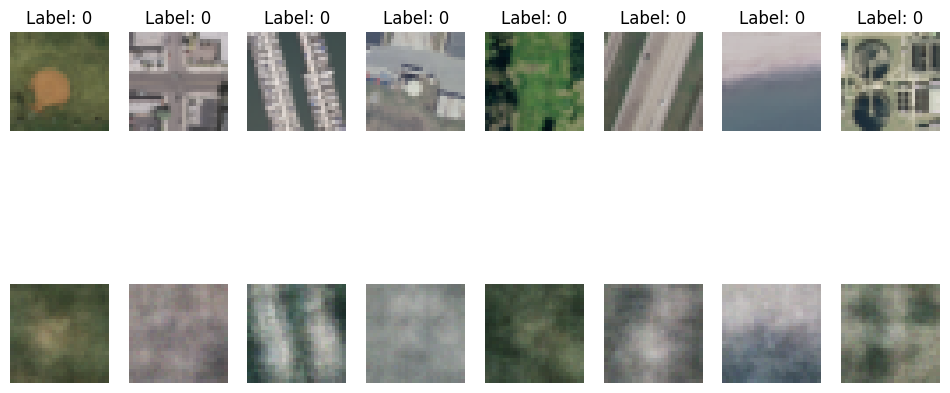

In [30]:
# ------------------------------
# Training Setup
# ------------------------------
model = HierarchicalVAE(input_dim=28*28*3, hidden_dim=400, z1_dim=20, z2_dim=10, dropout_p=0.2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
kl_beta = 0.5  # KL divergence weighting

def train(model, optimizer, loader, epoch, beta):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(loader):
        data = data.to(device)
        optimizer.zero_grad()
        x_logits, z1_mu, z1_logvar, z2_mu, z2_logvar, prior_mu, prior_logvar = model(data)
        loss = loss_function(x_logits, data, z1_mu, z1_logvar, z2_mu, z2_logvar, prior_mu, prior_logvar, beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 1 == 0:
            print(f"Epoch {epoch} Batch {batch_idx}: Loss per sample = {loss.item()/data.size(0):.4f}")
    print(f"Epoch {epoch} Average Loss: {train_loss/len(loader.dataset):.4f}")

# ------------------------------
# Training Loop
# ------------------------------
for epoch in range(1, num_epochs + 1):
    train(model, optimizer, train_loader, epoch, beta=kl_beta)

# ------------------------------
# Test: Reconstruct Images from the Test Dataset and Display Labels
# ------------------------------
model.eval()
with torch.no_grad():
    test_data, test_labels = next(iter(test_loader))
    test_data = test_data.to(device)
    x_logits, _, _, _, _, _, _ = model(test_data)
    reconstructions = torch.sigmoid(x_logits)
    reconstructions = reconstructions.view(-1, 3, 28, 28)

# ------------------------------
# Plot Original vs. Reconstructed Images with Labels
# ------------------------------
def imshow(img, title=None):
    npimg = img.cpu().numpy()
    # Convert tensor from (C, H, W) to (H, W, C) for plotting
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

n = 8
plt.figure(figsize=(12, 6))
# Plot original images with labels
for i in range(n):
    plt.subplot(2, n, i+1)
    imshow(test_data[i], title=f"Label: {test_labels[i].item()}")
# Plot reconstructed images
for i in range(n):
    plt.subplot(2, n, i+n+1)
    imshow(reconstructions[i])
plt.show()